## Introduction
---
- We have a dataset containing cat and non-cat images.
- The goal is to predict whether an image is of a cat or not using a self-implemented neural network that employs logistic regression as its core.
- The rule is to avoid using sklearn or any library for creating the model and related functions, which means we need to understand some mathematical concepts for this project.
- Here is a simple representation of what we are going to do:
<center><img src="images/deep_nn.png" style="width:650px;height:400px;"></center>

## Initial libraries and functions
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from PIL import Image
from activation_functions import sigmoid, sigmoid_backward, relu, relu_backward
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
def load_datasets(path_train, path_test):
    train = h5py.File(path_train, "r")
    test = h5py.File(path_test, "r")
    
    return (
        train["train_set_x"][:],
        train["train_set_y"][:],
        test["test_set_x"][:],
        test["test_set_y"][:],
    )

In [3]:
def categorical_label(label):
    return "cat" if label == 1 else "non-cat"

In [4]:
def print_mislabeled_images(X, y, p):
    """
    Plots images where predictions and truth were different.
    
    Parameters:
        X -- dataset
        y -- true labels
        p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title(f"Prediction: {categorical_label(p[0][index])} \nClass: {categorical_label(y[0][index])}")

## Logistic Neural Network Class Implementation
---

In [5]:
class LogisticNeuralNetwrok:
    def __init__(self, layers_dims: list[int], learning_rate = 0.0075, num_iterations = 3000):
        self.layers_dims = layers_dims
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.parameters = LogisticNeuralNetwrok.initialize_parameters(layers_dims)
    
    def fit(self, X, Y, print_cost=False):
        """
        Implements the L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
        
        Parameters:
            X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
            Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
            layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
            learning_rate -- learning rate of the gradient descent update rule
            num_iterations -- number of iterations of the optimization loop
            print_cost -- if True, it prints the cost every 100 steps
        """
        costs = [] # keep track of cost
        
        # Loop (gradient descent)
        for i in range(0, self.num_iterations):
            # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
            AL, caches = LogisticNeuralNetwrok.forward_propagate(X, self.parameters)
    
            # Compute cost.
            cost = LogisticNeuralNetwrok.compute_cost(AL, Y)
    
            # Backward propagation.
            grads = LogisticNeuralNetwrok.backward_propagate(AL, Y, caches)
            
            # Update parameters.
            parameters = LogisticNeuralNetwrok.update_parameters(self.parameters, grads, self.learning_rate)
     
            # Print the cost every 100 iterations
            if print_cost and i % 100 == 0 or i == self.num_iterations - 1:
                print(f"Cost after iteration {i}: {np.squeeze(cost)}")
            if i % 100 == 0 or i == self.num_iterations:
                costs.append(cost)

        self.parameters = parameters
        self.cost = cost

    def predict(self, X):
        """
        This method is used to predict the results of the neural network.
        
        Parameters:
            X -- data set of examples you would like to label
        
        Returns:
            p -- predictions for the given dataset X
        """        
        # Forward propagation
        probas, caches = LogisticNeuralNetwrok.forward_propagate(X, self.parameters)
        
        # convert probabilities to 0/1 predictions
        binary_classes = np.vectorize(lambda probability: 1 if probability > 0.5 else 0)
        p = binary_classes(probas)
        return p.astype(np.int64)

    @staticmethod
    def initialize_parameters(layer_dims):
        """
        Parameters:
            layer_dims -- python array (list) containing the dimensions of each layer in our network
        
        Returns:
            parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                bl -- bias vector of shape (layer_dims[l], 1)
        """
        parameters = {}
        L = len(layer_dims) # number of layers in the network
        
        for l in range(1, L):
            parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
            parameters[f'b{l}'] = np.zeros((layer_dims[l], 1))
            
        return parameters
        
    @staticmethod
    def linear_forward(A, W, b):
        """
        Implement the linear part of a layer's forward propagation.
    
        Parameters:
            A -- activations from previous layer (or input data): (size of previous layer, number of examples)
            W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
            b -- bias vector, numpy array of shape (size of the current layer, 1)
    
        Returns:
            Z -- the input of the activation function, also called pre-activation parameter 
            cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
        """
        Z = W.dot(A) + b
        cache = (A, W, b)
        return Z, cache

    @staticmethod
    def linear_activation_forward(A_prev, W, b, activation):
        """
        Implement the forward propagation for the LINEAR->ACTIVATION layer.
    
        Parameters:
            A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
            W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
            b -- bias vector, numpy array of shape (size of the current layer, 1)
            activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
        Returns:
            A -- the output of the activation function, also called the post-activation value 
            cache -- a python dictionary containing "linear_cache" and "activation_cache";
                     stored for computing the backward pass efficiently.
        """
        if activation == "sigmoid":
            Z, linear_cache = LogisticNeuralNetwrok.linear_forward(A_prev, W, b)
            A, activation_cache = sigmoid(Z)
        
        elif activation == "relu":
            Z, linear_cache = LogisticNeuralNetwrok.linear_forward(A_prev, W, b)
            A, activation_cache = relu(Z)
        
        cache = (linear_cache, activation_cache)
        
        return A, cache

    @staticmethod
    def forward_propagate(X, parameters):
        """
        Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation.
        
        Parameters:
            X -- data, numpy array of shape (input size, number of examples)
            parameters -- output of initialize_parameters()
            
        Returns:
            AL -- last post-activation value
            caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
        """
        caches = []
        A = X
        L = len(parameters) // 2 # number of layers in the neural network
        
        # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
        for l in range(1, L):
            A_prev = A 
            A, cache = LogisticNeuralNetwrok.linear_activation_forward(
                A_prev,
                parameters[f'W{l}'],
                parameters[f'b{l}'],
                activation = "relu"
            )
            caches.append(cache)
        
        # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
        AL, cache = LogisticNeuralNetwrok.linear_activation_forward(
            A,
            parameters[f'W{L}'],
            parameters[f'b{L}'],
            activation = "sigmoid"
        )
        caches.append(cache)
                
        return AL, caches

    @staticmethod
    def compute_cost(AL, Y):
        """
        Parameters:
            AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
            Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    
        Returns:
            cost -- cross-entropy cost
        """
        m = Y.shape[1]
    
        # Compute loss from aL and y.
        cost = (-np.dot(Y, np.log(AL).T) - np.dot(1 - Y, np.log(1 - AL).T)) / m
        cost = np.squeeze(cost) # To make sure cost's shape is what we expect (e.g. this turns [[17]] into 17).
        
        return cost

    @staticmethod
    def linear_backward(dZ, cache):
        """
        Implement the linear portion of backward propagation for a single layer (layer l).
    
        Parameters:
            dZ -- Gradient of the cost with respect to the linear output (of current layer l)
            cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer
    
        Returns:
            dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
            dW -- Gradient of the cost with respect to W (current layer l), same shape as W
            db -- Gradient of the cost with respect to b (current layer l), same shape as b
        """
        A_prev, W, b = cache
        m = A_prev.shape[1]
    
        dW = np.dot(dZ,A_prev.T) / m
        db = np.mean(dZ, axis = 1, keepdims = True)
        dA_prev = np.dot(W.T,dZ)
        
        return dA_prev, dW, db

    @staticmethod
    def linear_activation_backward(dA, cache, activation):
        """
        Implement the backward propagation for the LINEAR->ACTIVATION layer.
        
        Parameters:
            dA -- post-activation gradient for current layer l 
            cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
            activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
        
        Returns:
            dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
            dW -- Gradient of the cost with respect to W (current layer l), same shape as W
            db -- Gradient of the cost with respect to b (current layer l), same shape as b
        """
        linear_cache, activation_cache = cache
        
        if activation == "relu":
            dZ = relu_backward(dA, activation_cache)
            dA_prev, dW, db = LogisticNeuralNetwrok.linear_backward(dZ, linear_cache)
            
        elif activation == "sigmoid":
            dZ = sigmoid_backward(dA, activation_cache)
            dA_prev, dW, db = LogisticNeuralNetwrok.linear_backward(dZ, linear_cache)
        
        return dA_prev, dW, db

    @staticmethod
    def backward_propagate(AL, Y, caches):
        """
        Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
        
        Parameters:
            AL -- probability vector, output of the forward propagation (forward_propagate())
            Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
            caches -- list of caches containing:
                        every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                        the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
        
        Returns:
            grads -- A dictionary with the gradients
                     grads["dA" + str(l)] = ... 
                     grads["dW" + str(l)] = ...
                     grads["db" + str(l)] = ... 
        """
        grads = {}
        L = len(caches) # the number of layers
        # m = AL.shape[1]
        Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
        
        # Initializing the backpropagation
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        
        # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
        current_cache = caches[L-1]
        grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = LogisticNeuralNetwrok.linear_activation_backward(
            dAL,
            current_cache,
            activation = "sigmoid"
        )
        
        # lth layer: (RELU -> LINEAR) gradients.
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = LogisticNeuralNetwrok.linear_activation_backward(
                grads["dA" + str(l + 1)],
                current_cache,
                activation = "relu"
            )
            grads["dA" + str(l)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp
    
        return grads

    @staticmethod
    def update_parameters(parameters, grads, learning_rate):
        """
        Update parameters using gradient descent
        
        Parameters:
            parameters -- python dictionary containing your parameters 
            grads -- python dictionary containing your gradients, output of backward_propagate
        
        Returns:
            parameters -- python dictionary containing your updated parameters 
                          parameters[f"W{l}"] = ... 
                          parameters[f"b{l}"] = ...
        """
        
        L = len(parameters) // 2 # number of layers in the neural network
    
        # Update rule for each parameter.
        for l in range(L):
            parameters[f"W{l+1}"] = parameters[f"W{l+1}"] - learning_rate * grads[f"dW{l+1}"]
            parameters[f"b{l+1}"] = parameters[f"b{l+1}"] - learning_rate * grads[f"db{l+1}"]
            
        return parameters

In [6]:
np.random.seed(1) # just to get make random initialization gives the same number each time.

## Exploratory data analysis (EDA)
---
- It seems we have 259 pictures in total and each pictures is 64x64 pixel(each pixel contains 3 numerical data represent RGB format)

In [7]:
train_X, train_y, test_X, test_y = load_datasets("datasets/train_catvnoncat.h5", "datasets/test_catvnoncat.h5")

In [8]:
m_train = train_X.shape[0]
m_test = test_X.shape[0]
num_px = train_X.shape[1]

print (f"Number of training examples : {m_train}")
print (f"Number of testing examples  : {m_test}")
print (f"Each image is of size       : {train_X.shape[1:]}")
print (f"train_X shape               : {train_X.shape}")
print (f"train_y shape               : {train_y.shape}")
print (f"test_X shape                : {test_X.shape}")
print (f"test_y shape                : {test_y.shape}")

Number of training examples : 209
Number of testing examples  : 50
Each image is of size       : (64, 64, 3)
train_X shape               : (209, 64, 64, 3)
train_y shape               : (209,)
test_X shape                : (50, 64, 64, 3)
test_y shape                : (50,)


y = 1. Its a cat picture.


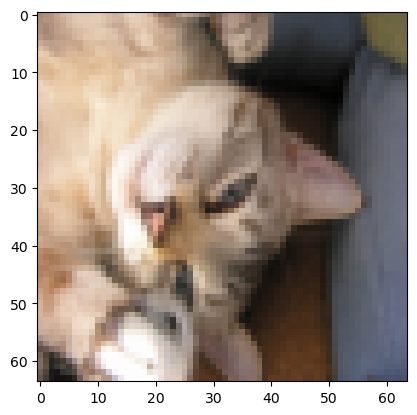

In [9]:
index = 110
plt.imshow(train_X[index])
print(f"y = {train_y[index]}. Its a {categorical_label(train_y[index])} picture.")

### Proprocessing
- Converting y 1D array into a row vector.
- Flattening the X matrix and normalizing its values.

In [10]:
# Turning [1, 0, 1, ...] -> [[1, 0, 1, ...]]
train_y = train_y.reshape((1, train_y.shape[0])) 
test_y = test_y.reshape((1, test_y.shape[0]))

In [11]:
train_X = train_X.reshape(train_X.shape[0], -1).T # The "-1" makes reshape flatten the remaining dimensions
test_X = test_X.reshape(test_X.shape[0], -1).T

train_X = train_X / 255.
test_X = test_X / 255.

In [12]:
print (f"train_X shape               : {train_X.shape}")
print (f"train_y shape               : {train_y.shape}")
print (f"test_X shape                : {test_X.shape}")
print (f"test_y shape                : {test_y.shape}")

train_X shape               : (12288, 209)
train_y shape               : (1, 209)
test_X shape                : (12288, 50)
test_y shape                : (1, 50)


## Logistic neural network (binary classifier)
---

In [13]:
layers_dims = [12288, 20, 7, 5, 1]

model = LogisticNeuralNetwrok(layers_dims, num_iterations = 2500)

### Training our model and evaluating it

In [14]:
model.fit(X=train_X, Y=train_y, print_cost=True)

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822915
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101356
Cost after iteration 400: 0.5670473268366111
Cost after iteration 500: 0.54013766345478
Cost after iteration 600: 0.5279299569455268
Cost after iteration 700: 0.46547737717668514
Cost after iteration 800: 0.36912585249592794
Cost after iteration 900: 0.3917469743480535
Cost after iteration 1000: 0.31518698886006163
Cost after iteration 1100: 0.27269984417893844
Cost after iteration 1200: 0.2374185340026814
Cost after iteration 1300: 0.19960120532208647
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.1611885466582775
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.13777487812972947
Cost after iteration 1800: 0.1297401754919012
Cost after iteration 1900: 0.12122535068005211
Cost after iteration 2000: 0.1138206066863371
Cost after iteration 2100: 0.1078392852

In [15]:
y_hat = model.predict(test_X)

print(classification_report(y_pred=y_hat.squeeze(), y_true=test_y.squeeze()))

              precision    recall  f1-score   support

           0       0.77      0.59      0.67        17
           1       0.81      0.91      0.86        33

    accuracy                           0.80        50
   macro avg       0.79      0.75      0.76        50
weighted avg       0.80      0.80      0.79        50



### Plotting mislabeled images

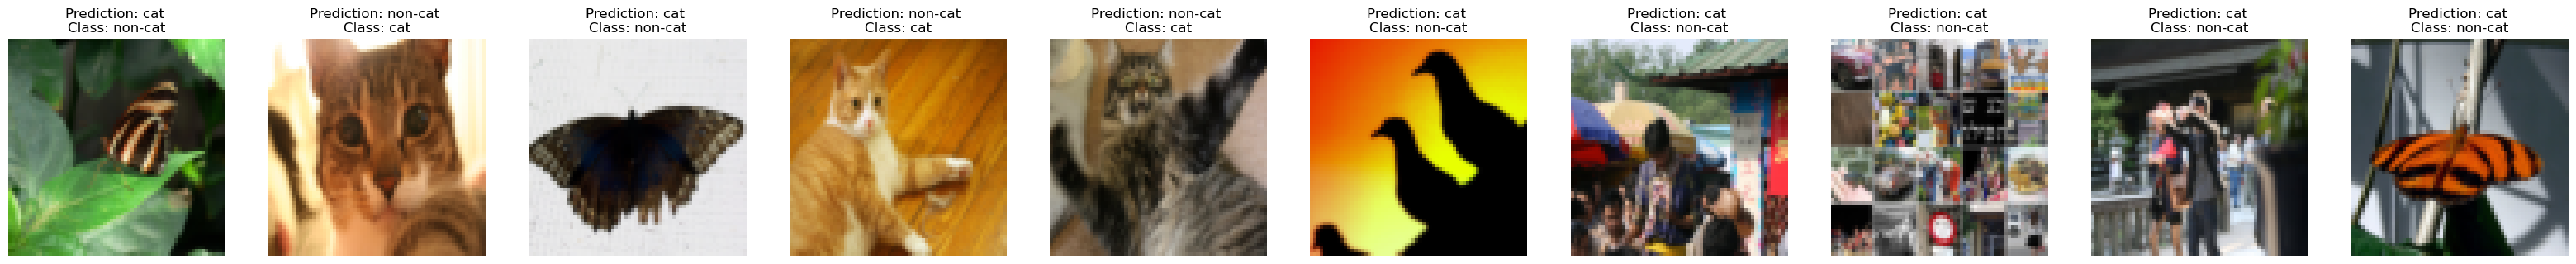

In [16]:
plt.figure(figsize=(40, 40))
print_mislabeled_images(test_X, test_y, y_hat)

### Plotting the confusion matrix

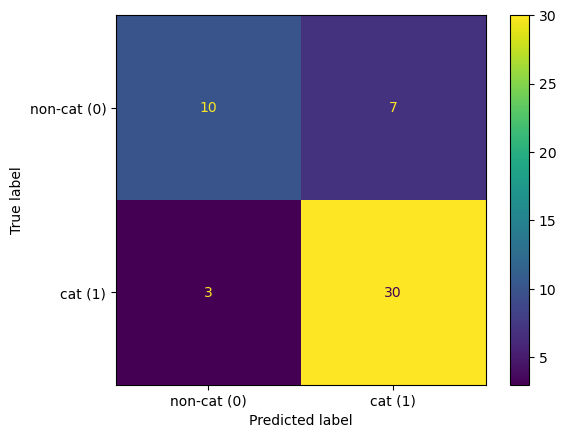

In [17]:
cm = confusion_matrix(test_y.squeeze(), y_hat.squeeze())

cm_display = ConfusionMatrixDisplay(cm, display_labels=['non-cat (0)', 'cat (1)'])
cm_display.plot()

### Try it with your own image

True y = 1.
your model predicts a cat (y=1) picture.


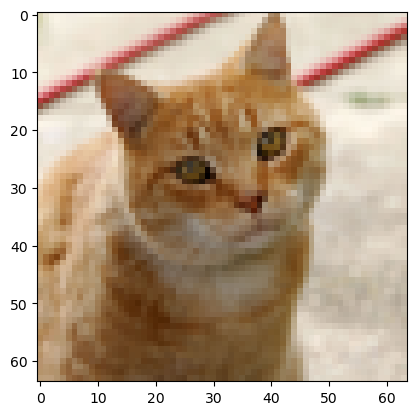

In [18]:
img_path = "images/my_picture.jpg" # change this to the name of your image file 
label = 1 # the true class of your image (1 -> cat, 0 -> non-cat)

image = np.array(Image.open(img_path).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

predicted_label = model.predict(image)


print(f"True y = {label}.")
print(f"your model predicts a {categorical_label(predicted_label[0][0])} (y={predicted_label.squeeze()}) picture.")

---
<center>
    <h3>
        <i>
            This concludes the notebook. Feel free to reach out with any questions or suggestions!
        </i>
    </h3>
</center>